#  The Winton Stock Market Challenge 📈

This notebook contains data analysis and modeling of a stock data. Each row of the data contains data points of a 5-day windows, 25 masked features, and weights for intraday and interday predictions.

The given weights are used in the metrics calculation. The formula for the metric is as follows.

$$
WMAE = \frac{1}{n} \sum_{i=1}^{n} w_i \cdot |y_i - \hat{y_i}|
$$

Link to **[Kaggle challenge](https://www.kaggle.com/competitions/the-winton-stock-market-challenge)**. \
Link to **[Git repository](https://github.com/prompath/kaggle-the-winton-stock-market-challenge)**.

# Data Dictionary 📑

- **Feature_1 to Feature_25:** different features relevant to prediction
- **Ret_MinusTwo:**  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
- **Ret_MinusOne:** this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
- **Ret_2 to Ret_120:** these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 
- **Ret_121 to Ret_180:** intraday returns over approximately one minute on day D. **These are the target variables you need to predict as {id}_{1-60}.** 
- **Ret_PlusOne:** this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1 day). **This is a target variable you need to predict as {id}\_61.** 
- **Ret_PlusTwo:** this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) **This is a target variable you need to predict as {id}_62.**
- **Weight_Intraday:** weight used to evaluate intraday return predictions Ret 121 to 180
- **Weight_Daily:** weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

![img](https://storage.googleapis.com/kaggle-competitions/kaggle/4504/media/Presentation1%20(1).jpg)

# Libraries 📚

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns

# Paths ⛕

In [7]:
TRAIN_PATH = "dataset/train.csv"
TEST_PATH = "dataset/test.csv"
SUBMISSION_TEST_PATH = "dataset/test_2.csv"

# Import Raw Data 🥩

In [8]:
raw_df = pd.read_csv(TRAIN_PATH)

In [92]:
def display_all_columns(df: pd.DataFrame):
    with pd.option_context('display.max_columns', None): 
        display(df)

In [93]:
display_all_columns(raw_df.head())

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,Ret_14,Ret_15,Ret_16,Ret_17,Ret_18,Ret_19,Ret_20,Ret_21,Ret_22,Ret_23,Ret_24,Ret_25,Ret_26,Ret_27,Ret_28,Ret_29,Ret_30,Ret_31,Ret_32,Ret_33,Ret_34,Ret_35,Ret_36,Ret_37,Ret_38,Ret_39,Ret_40,Ret_41,Ret_42,Ret_43,Ret_44,Ret_45,Ret_46,Ret_47,Ret_48,Ret_49,Ret_50,Ret_51,Ret_52,Ret_53,Ret_54,Ret_55,Ret_56,Ret_57,Ret_58,Ret_59,Ret_60,Ret_61,Ret_62,Ret_63,Ret_64,Ret_65,Ret_66,Ret_67,Ret_68,Ret_69,Ret_70,Ret_71,Ret_72,Ret_73,Ret_74,Ret_75,Ret_76,Ret_77,Ret_78,Ret_79,Ret_80,Ret_81,Ret_82,Ret_83,Ret_84,Ret_85,Ret_86,Ret_87,Ret_88,Ret_89,Ret_90,Ret_91,Ret_92,Ret_93,Ret_94,Ret_95,Ret_96,Ret_97,Ret_98,Ret_99,Ret_100,Ret_101,Ret_102,Ret_103,Ret_104,Ret_105,Ret_106,Ret_107,Ret_108,Ret_109,Ret_110,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120,Ret_121,Ret_122,Ret_123,Ret_124,Ret_125,Ret_126,Ret_127,Ret_128,Ret_129,Ret_130,Ret_131,Ret_132,Ret_133,Ret_134,Ret_135,Ret_136,Ret_137,Ret_138,Ret_139,Ret_140,Ret_141,Ret_142,Ret_143,Ret_144,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,NaN,NaN,0.49,5.0,1.842984,27.053679,1.0,NaN,NaN,-0.925463,2.0,NaN,-0.489492,NaN,NaN,NaN,0.055275,-0.010770,0.000003,-0.000734,-0.000738,-0.000007,0.000423,0.000438,-0.000076,0.000645,-0.000006,0.000006,NaN,-0.000156,NaN,NaN,-0.000430,-1.964625e-05,0.000002,-0.000031,NaN,NaN,-7.539950e-06,NaN,0.000416,-0.000164,-0.000009,-0.000438,NaN,0.000010,-7.176461e-04,-0.000162,NaN,NaN,NaN,-0.000582,0.001003,-0.000010,0.000134,0.000014,-0.000142,-0.001003,-0.000007,-0.000005,-1.277039e-05,NaN,0.000706,-0.000734,-7.311366e-04,-0.001996,-0.000153,0.000133,NaN,NaN,-0.000007,0.000713,0.000009,NaN,-0.000432,-0.001152,-0.000723,9.982299e-07,-0.003579,0.000435,-0.000012,-0.000132,0.000004,0.000418,-0.000011,NaN,-0.002724,-0.002996,0.000129,0.000012,-0.000002,-1.369941e-04,-0.003537,-0.000142,0.000135,0.000020,-1.318606e-04,0.000449,-0.000008,0.000006,0.000282,-1.390130e-04,-1.284489e-04,0.000005,-0.000005,-1.693501e-03,-0.002141,0.000003,-0.000274,-0.000015,0.001279,0.000282,-0.000003,-0.000156,0.000024,-0.000560,-0.000580,0.000138,-0.002277,0.000125,0.000406,-0.000427,-0.000013,-0.000843,1.666111e-04,0.000569,0.000695,NaN,0.000700,-0.000843,0.000268,-0.000415,-0.001133,0.000004,-0.000137,-0.000009,1.340780e-04,-0.000137,-0.000565,-0.000704,-0.005605,0.000826,0.001966,0.002676,0.000422,-0.000428,-0.000539,-0.002113,-0.001400,-0.000017,-0.002801,-0.000003,0.002099,0.000698,0.000547,-0.001976,0.000012,0.001112,0.000284,0.000003,-0.001976,-0.000842,-0.001390,0.000148,2.846942e-04,0.001254,-0.000130,0.000126,0.000978,0.000151,0.002642,-0.000017,0.000140,0.000015,-0.000011,0.001683,-0.000286,0.000010,0.000152,0.000579,-1.501973e-04,0.000822,0.001392,0.000292,0.000002,0.001133,-0.000134,0.001539,-0.000142,0.000861,0.000544,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,NaN,-0.409923,0.71,9.0,1.577586,9.546915,1.0,-0.949891,0.917958,-0.897067,9.0,0.886205,-0.151805,1.239856,0.953424,-0.709462,0.009748,0.002987,-0.000487,0.000475,0.000002,-0.000002,-0.000523,-0.000255,-0.000008,0.000048,-0.000312,-0.000742,-0.000009,-0.000248,0.000487,0.000256,-0.000508,2.495416e-04,0.000015,0.000008,-0.000251,-0.000519,-5.029784e-04,0.000240,0.000248,0.000495,-0.000243,-0.

Just from displaying the first few rows we can see that there can be missing values in both the feature columns and the return data.

~~**TODO:** Check for the amount of missing data for features, return, and weights (just in case).~~

In [10]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 211 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Id               int64  
 1    Feature_1        float64
 2    Feature_2        float64
 3    Feature_3        float64
 4    Feature_4        float64
 5    Feature_5        float64
 6    Feature_6        float64
 7    Feature_7        int64  
 8    Feature_8        float64
 9    Feature_9        float64
 10   Feature_10       float64
 11   Feature_11       float64
 12   Feature_12       float64
 13   Feature_13       float64
 14   Feature_14       float64
 15   Feature_15       float64
 16   Feature_16       float64
 17   Feature_17       float64
 18   Feature_18       float64
 19   Feature_19       float64
 20   Feature_20       float64
 21   Feature_21       float64
 22   Feature_22       float64
 23   Feature_23       float64
 24   Feature_24       float64
 25   Feature_25       float64
 26   Ret_MinusTwo    

Using .info() method shows that besides Id and Feature_7 column, the data types of every columns are in float64. No type casting is needed. We can proceed to the next step, creating the test set with random sampling for **20%** of the data. But first, let's make sure every rows in raw data have weights before sampling since we can't compute metrics without them.

In [30]:
raw_df["Weight_Intraday"].isna().sum()

0

In [31]:
raw_df["Weight_Daily"].isna().sum()

0

No missing weights. We can proceed with the sampling.

In [14]:
test_df = raw_df.sample(frac=0.2, random_state=42).sort_index()
test_df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06
7,8,NaN,2.582955,0.157344,0.617261,8.0,-0.177333,92214,0.2119,8.0,...,-0.000247,-0.000250,0.000010,1.620296e-05,0.000245,0.000006,0.020268,-0.059093,1.349917e+06,1.687396e+06
13,14,NaN,0.480362,0.915407,1.381156,7.0,0.223401,35023,0.2138,10.0,...,0.000295,-0.001858,0.001133,-1.288622e-03,-0.000433,-0.000574,-0.010936,-0.019700,1.460081e+06,1.825101e+06
23,24,NaN,-1.833909,0.807421,0.396305,7.0,0.225614,57773,0.2986,7.0,...,0.000663,-0.003362,-0.002676,2.674716e-03,0.002692,-0.003376,0.076162,0.013566,1.208516e+06,1.510645e+06


In [15]:
test_df.tail()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
39973,39974,NaN,NaN,0.247709,0.708384,1.0,0.516685,39562,0.3318,12.0,...,-0.000635,0.000625,0.000010,0.000950,1.271857e-05,-2.605154e-07,0.016990,0.000616,1.518609e+06,1.898261e+06
39974,39975,NaN,-0.795393,0.812479,1.182253,2.0,0.435337,34124,0.3650,10.0,...,-0.001339,0.000944,0.000387,0.000577,-2.094398e-06,1.228960e-05,0.008246,-0.025444,1.467096e+06,1.833870e+06
39977,39978,NaN,1.584213,1.485364,NaN,5.0,0.181444,48365,0.2119,11.0,...,0.000376,-0.000660,0.000392,-0.000129,-3.927012e-04,3.845017e-04,0.001195,-0.001933,1.813249e+06,2.266561e+06
39986,39987,NaN,-1.304033,1.063957,0.448434,9.0,0.276835,34425,0.2208,11.0,...,0.000003,-0.000210,0.000007,0.000195,2.002236e-04,-1.097263e-04,-0.030169,0.001835,1.388133e+06,1.735166e+06
39992,39993,NaN,-0.787167,1.189032,0.168022,10.0,0.187430,82639,0.0142,8.0,...,0.000223,-0.000005,0.000857,-0.000183,-9.980441e-07,-5.580793e-06,0.002926,0.005249,1.411322e+06,1.764153e+06


In [16]:
test_df.shape

(8000, 211)

Everything about the test set seems to be in order. We'll just save it and use it later to validate our model performance.

In [18]:
test_df.to_csv(TEST_PATH, index=False)

The data points that are in the test set must be removed from the raw data to create training set.

In [23]:
train_df = raw_df[~raw_df["Id"].isin(test_df["Id"])]
train_df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-0.000695,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,0.000116,0.000532,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,0.000288,-0.000128,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
5,6,NaN,NaN,-0.680515,NaN,1.0,0.227034,24099,0.2064,8.0,...,0.000242,0.001412,0.001880,-0.000946,0.000471,0.001193,0.031098,-0.006551,1.431110e+06,1.788888e+06
6,7,NaN,-0.230636,-0.227021,-0.084126,7.0,-0.095007,39351,0.3650,13.0,...,0.000326,-0.000408,0.000086,-0.000012,-0.000006,0.000640,-0.011105,-0.030745,1.719166e+06,2.148958e+06


In [24]:
train_df.tail()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
39995,39996,NaN,NaN,0.822371,NaN,1.0,2.182050,23729,0.2208,12.0,...,0.000623,0.000504,1.490012e-03,0.000623,-0.000516,-0.000876,-0.024270,0.010143,1.413891e+06,1.767363e+06
39996,39997,NaN,0.747556,-0.489418,-0.267193,10.0,-0.454329,56222,0.2323,8.0,...,0.000649,0.001290,-6.031396e-07,-0.001278,-0.000658,0.000628,0.017855,-0.000094,1.468998e+06,1.836248e+06
39997,39998,NaN,NaN,-0.914701,-1.013004,2.0,-0.701013,7024,0.3418,10.0,...,0.001375,0.000005,7.888841e-04,0.000211,-0.000573,-0.001568,0.011602,-0.006539,1.812824e+06,2.266030e+06
39998,39999,NaN,-0.021457,1.021284,NaN,3.0,1.092849,27376,0.2119,13.0,...,0.000273,0.000017,2.471045e-04,-0.000138,0.000015,-0.000123,-0.018877,-0.011572,1.507918e+06,1.884897e+06
39999,40000,NaN,1.093868,-0.677391,-0.604479,7.0,NaN,4141,0.2254,NaN,...,-0.000914,-0.002752,1.350722e-03,0.000903,0.003667,0.002761,0.024405,-0.024345,1.535389e+06,1.919237e+06


In [25]:
train_df.shape

(32000, 211)

# Exploratory Data Analysis 🔍

For easier slicing, let's make lists of columns by types.

In [170]:
feature_cols = [f"Feature_{i}" for i in range(1, 26)]
intra_ret_cols = [f"Ret_{i}" for i in range(2, 181)]
inter_ret_cols = ["Ret_MinusTwo", "Ret_MinusOne", "Ret_PlusOne", "Ret_PlusTwo"]

## Missing Values

In [189]:
def plot_missing(df: pd.DataFrame, name: str):
    nrows, ncols = df.shape
    notna_df = df.notna().sum().to_frame().T
    percent_notna_df = (notna_df / nrows) * 100
    fig, ax = plt.subplots(1, 1, figsize=(7, ncols * 0.25))
    sns.barplot(percent_notna_df, orient="h", ax=ax)
    ax.set_xlim(0, 110)
    ax.bar_label(ax.containers[0], fmt="%.2f");
    ax.set_title(f"Percentage of Non Null Values in {name}")
    ax.set_xlabel("%")
    ax.set_ylabel("Column")

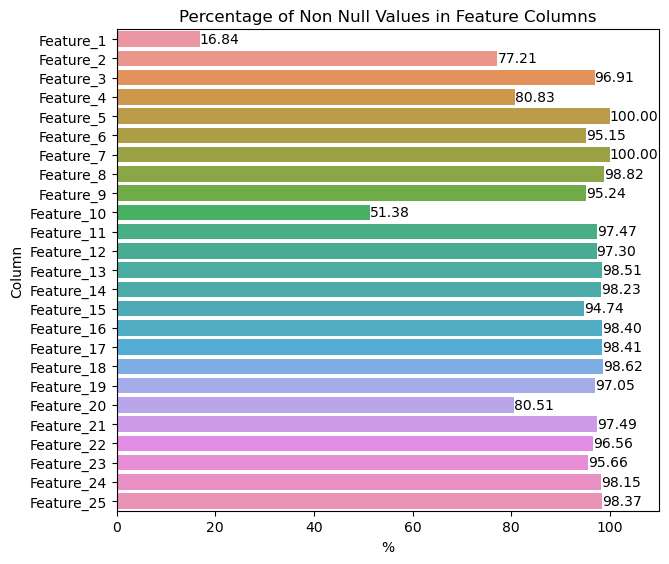

In [190]:
plot_missing(train_df.loc[:, feature_cols], "Feature Columns")

Most Feature columns have high availability of the data with less than 10% missing data. Anyhow, there are some columns that have around 80% of the data available which are **Feature_2, Feature_4, and Feature_20.** Also, there are some that have low data availability, namely, **Feature_10** has about half while **Feature_1** has only 16.84%!

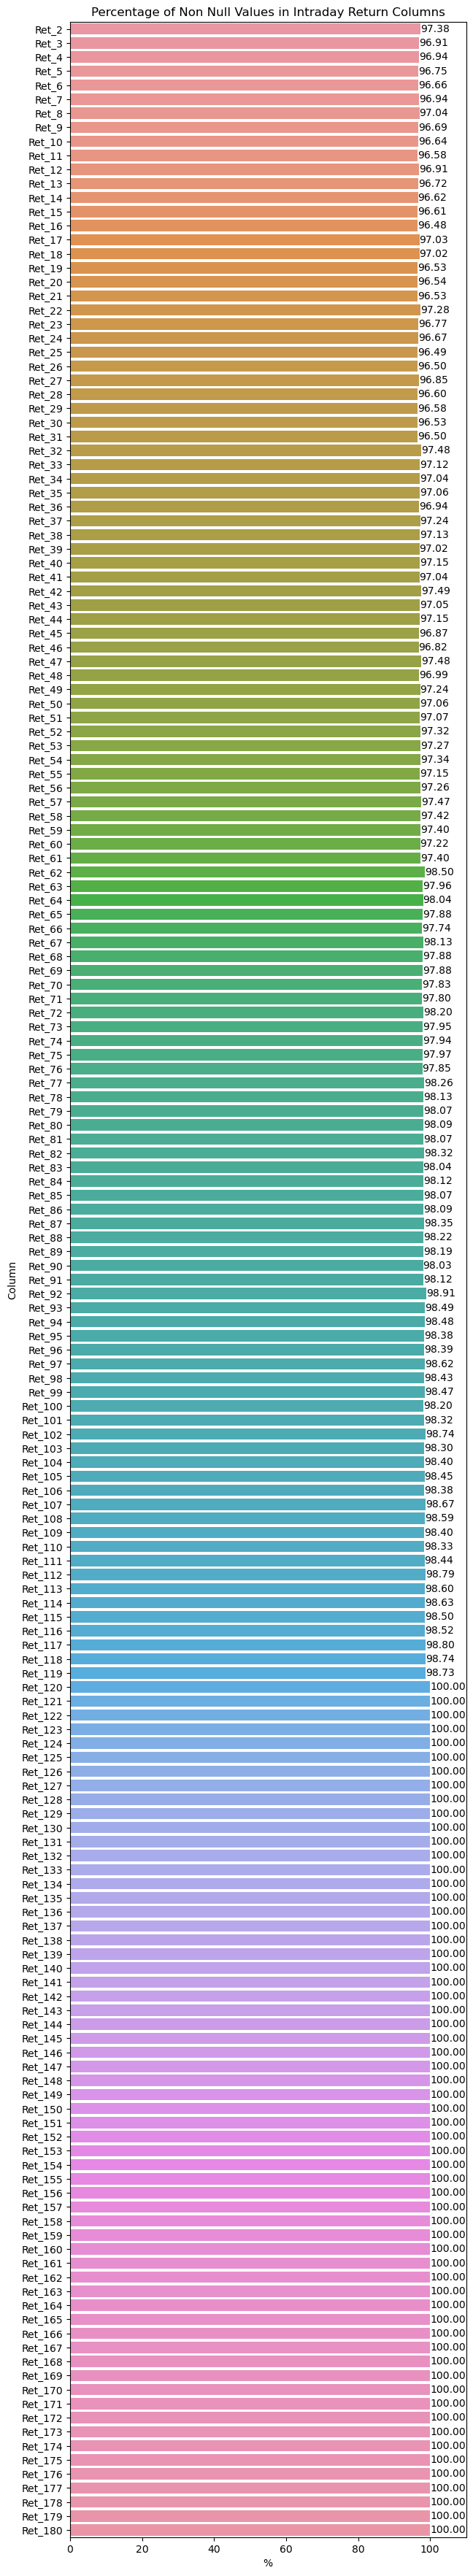

In [191]:
plot_missing(train_df.loc[:, intra_ret_cols], "Intraday Return Columns")

Intraday return data is close to being full. With every columns having over 96% of the data to be non-missing, and since imputation of consecutive time series data points can be done easily with LOCF and LOCB, this means we don't have to worry about missing data of intraday return (for now).

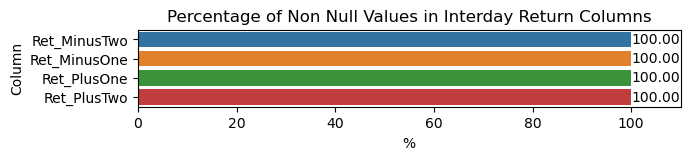

In [192]:
plot_missing(train_df.loc[:, inter_ret_cols], "Interday Return Columns")

No missing data for interday returns. We can proceed with these columns as is.